In [9]:
from pathlib import Path
import pandas as pd
import numpy as np
results_folder = Path('/home/engaclew/neurogen/results/pyannote_metrics')

# Load f-score
fscore_lena = pd.read_csv(results_folder / 'its_eaf_an1' / 'fscore_30mn_clips.csv')
fscore_vtc = pd.read_csv(results_folder / 'vtc_eaf_an1' / 'fscore_30mn_clips.csv')
# Order
desired_order = ['low_risk', 'angelman_syndrome', 'fragile_x_syndrome', 'down_syndrome', 'autism_sibling']
fscore_lena['group_id'] = pd.Categorical(fscore_lena['group_id'], categories=desired_order, ordered=True)
fscore_vtc['group_id'] = pd.Categorical(fscore_vtc['group_id'], categories=desired_order, ordered=True)
fscore_lena = fscore_lena.sort_values('group_id')
fscore_vtc = fscore_vtc.sort_values('group_id')

print('Computing on %d chunks' % len(fscore_lena))
def compute_fscore(fscore_data):
    speakers = ['CHI', 'FEM', 'MAL', 'OCH']
    for speaker in speakers:
        # Precision = 1 if retrieved == 0 (all retrieved instances are correct since there was no retrieve instances
        fscore_data[f'precision_{speaker}'] = np.where(
            fscore_data[f'retrieved_{speaker}'] == 0,
            1,
            fscore_data[f'relevant retrieved_{speaker}'] / fscore_data[f'retrieved_{speaker}']
        )
    
        # Recall = 1 if relevant is 0 (all actual instances have been found since there was no example)
        fscore_data[f'recall_{speaker}'] = np.where(
            (fscore_data[f'relevant_{speaker}'] == 0),
            1,
            fscore_data[f'relevant retrieved_{speaker}'] / fscore_data[f'relevant_{speaker}']
        )
    
        # F-score calculation
        numerator = 2 * fscore_data[f'precision_{speaker}'] * fscore_data[f'recall_{speaker}']
        denominator = fscore_data[f'precision_{speaker}'] + fscore_data[f'recall_{speaker}']
        fscore_data[f'fscore_{speaker}'] = np.where(denominator != 0, numerator / denominator, 0)

    total_duration = (fscore_data['relevant_CHI'] + fscore_data['relevant_OCH'] + 
                 fscore_data['relevant_FEM'] + fscore_data['relevant_MAL'])

    total_global_duration = fscore_data[['relevant_CHI', 'relevant_OCH', 'relevant_FEM', 'relevant_MAL']].sum().sum()
    global_weights = {spk: fscore_data[f'relevant_{spk}'].sum() / total_global_duration for spk in speakers}
    print(f'Weights: {global_weights}')
    for metric in ['precision', 'recall', 'fscore']:
        fscore_data[f'weighted_{metric}'] = 100*sum(
                fscore_data[f'{metric}_{spk}'] * global_weights[spk] 
                for spk in speakers
            )
        fscore_data[metric] = 100 * fscore_data[[f'{metric}_{spk}' for spk in speakers]].mean(axis=1)
    return fscore_data

fscore_lena = compute_fscore(fscore_lena)
fscore_vtc = compute_fscore(fscore_vtc)


Computing on 50 chunks
Weights: {'CHI': 0.33801821016216804, 'FEM': 0.40483508026272125, 'MAL': 0.12314295312470816, 'OCH': 0.13400375645040255}
Weights: {'CHI': 0.33801821016216804, 'FEM': 0.40483508026272125, 'MAL': 0.12314295312470816, 'OCH': 0.13400375645040255}


In [40]:
fscore_lena.iloc[34]

recording_id              20200312_145204_022874.wav
group_id                               down_syndrome
retrieved_CHI                               123790.0
relevant_CHI                                267716.0
relevant retrieved_CHI                       46441.0
fscore_CHI                                  0.237243
retrieved_OCH                                24480.0
relevant_OCH                                   948.0
relevant retrieved_OCH                           0.0
fscore_OCH                                       0.0
retrieved_FEM                               136030.0
relevant_FEM                                106357.0
relevant retrieved_FEM                       15506.0
fscore_FEM                                  0.127944
retrieved_MAL                                81080.0
relevant_MAL                                120733.0
relevant retrieved_MAL                       18823.0
fscore_MAL                                  0.186539
precision_CHI                                0

lena [54.774974729226486, 43.99787490594644, 44.814932923750895]
vtc [40.59133986573283, 66.5505839505827, 47.91387771695553]
lena [54.774974729226486, 43.99787490594644, 44.814932923750895]
vtc [40.59133986573283, 66.5505839505827, 47.91387771695553]
lena [54.774974729226486, 43.99787490594644, 44.814932923750895]
vtc [40.59133986573283, 66.5505839505827, 47.91387771695553]


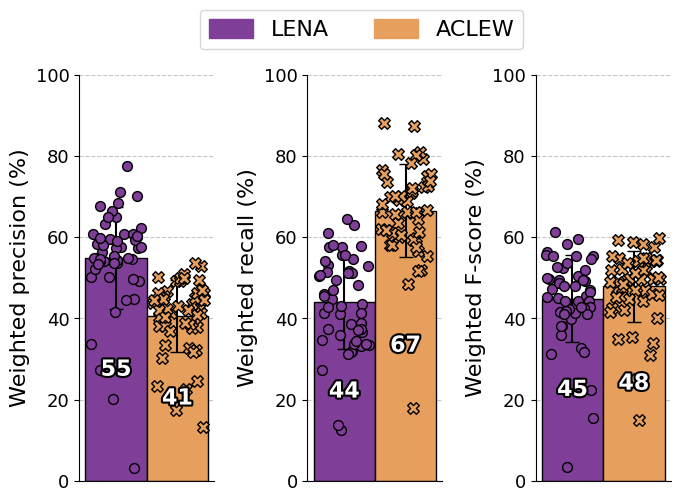

In [11]:
# SEGMENTATION SCORES
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import matplotlib.patheffects as path_effects

matplotlib.rcParams.update({'font.size': 16, 'legend.handleheight': 1, 'hatch.linewidth': 1.0,
                          'lines.markersize': 10, 'lines.linewidth': 2, 'errorbar.capsize': 5,
                           'xtick.labelsize': 13, 'ytick.labelsize': 13})

cm = 1/2.54


lena_color = '#7F3E97'
aclew_color = '#E69F5C' 
metric_name = ['Weighted precision (%)', 'Weighted recall (%)', 'Weighted F-score (%)']
def plot_corpus_metrics(fscore_lena, fscore_vtc):
    metrics = ['weighted_precision', 'weighted_recall', 'weighted_fscore']
    fig_width = 6 * len(metrics)
    fig, axes = plt.subplots(1, len(metrics), figsize=(fig_width*cm, 12*cm))
    width = 0.35
    jitter_width = 0.15
    alpha = 1
    
    # Get means and stds for each metric at corpus level
    lena_means = [fscore_lena[f'{m}'].mean() for m in metrics]
    lena_stds = [fscore_lena[f'{m}'].std() for m in metrics]
    vtc_means = [fscore_vtc[f'{m}'].mean() for m in metrics]
    vtc_stds = [fscore_vtc[f'{m}'].std() for m in metrics]
    
    # Create each subplot
    for i, (metric, ax) in enumerate(zip(metrics, axes)):
        # Plot bars with error bars
        print("lena", lena_means)
        ax.bar(-width/2, 
               lena_means[i], 
               width, 
               yerr=lena_stds[i],
               label='LENA', 
               color=lena_color, 
               edgecolor='black',
               alpha=alpha,
               zorder=2,
               error_kw=dict(ecolor='black', elinewidth=1.5, capsize=5, capthick=1))
        print("vtc", vtc_means)
        ax.bar(width/2, 
               vtc_means[i], 
               width,
               yerr=vtc_stds[i],
               label='ACLEW', 
               color=aclew_color, 
               edgecolor='black',
               alpha=alpha,
               zorder=2,
               error_kw=dict(ecolor='black', elinewidth=1.5, capsize=5, capthick=1))
        
        # Add scatter points for individual measurements
        # LENA scatter points
        jitter = np.random.uniform(-jitter_width, jitter_width, size=len(fscore_lena))
        ax.scatter([-width/2 + j for j in jitter], 
                  fscore_lena[metric],
                  color=lena_color,
                  edgecolor='black',
                  s=50,
                  zorder=3)
        
        # ACLEW scatter points
        jitter = np.random.uniform(-jitter_width, jitter_width, size=len(fscore_vtc))
        ax.scatter([width/2 + j for j in jitter], 
                  fscore_vtc[metric],
                  color=aclew_color,
                  edgecolor='black',
                  s=70,
                  marker='X',
                  zorder=3)
        
        ax.set_xticks([])
        ax.set_ylabel(metric_name[i])
        ax.set_ylim(0, 100)
        ax.grid(True, linestyle='--', alpha=0.7, zorder=0)
        
        # Add value labels on top of bars
        for x, value in [(-width/2, lena_means[i]), (width/2, vtc_means[i])]:
            text = ax.text(x, value/2, f'{value:.0f}', 
                    ha='center', va='center', color='white', 
                    weight='bold', zorder=3, size=16)
            # Add black outline to make text more visible
            text.set_path_effects([path_effects.withStroke(linewidth=3, foreground='black')])
        
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    
    handles = [plt.Rectangle((0,0),1,1, color=lena_color),  plt.Rectangle((0,0),1,1, color=aclew_color)]
    labels = ['LENA', 'ACLEW']
    fig.legend(handles, labels, ncol=2, bbox_to_anchor=(0.53, 1.03), loc='center')
    plt.tight_layout()
    return fig, axes

fig, axes = plot_corpus_metrics(fscore_lena, fscore_vtc)
plt.savefig('/home/engaclew/neurogen/figures/30mn/segmentation_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

In [12]:
results_folder = Path('/home/engaclew/neurogen/results/agreement')
kappa_lena = pd.read_csv(results_folder / 'its_eaf_an1' / 'kappa_30mn_clips.csv')
kappa_vtc = pd.read_csv(results_folder / 'vtc_eaf_an1' / 'kappa_30mn_clips.csv')
kappa_lena['kappa'] = (kappa_lena['kappa_CHI']+kappa_lena['kappa_OCH']+kappa_lena['kappa_MAL']+kappa_lena['kappa_FEM'])/4
kappa_vtc['kappa'] = (kappa_vtc['kappa_CHI']+kappa_vtc['kappa_OCH']+kappa_vtc['kappa_MAL']+kappa_vtc['kappa_FEM'])/4

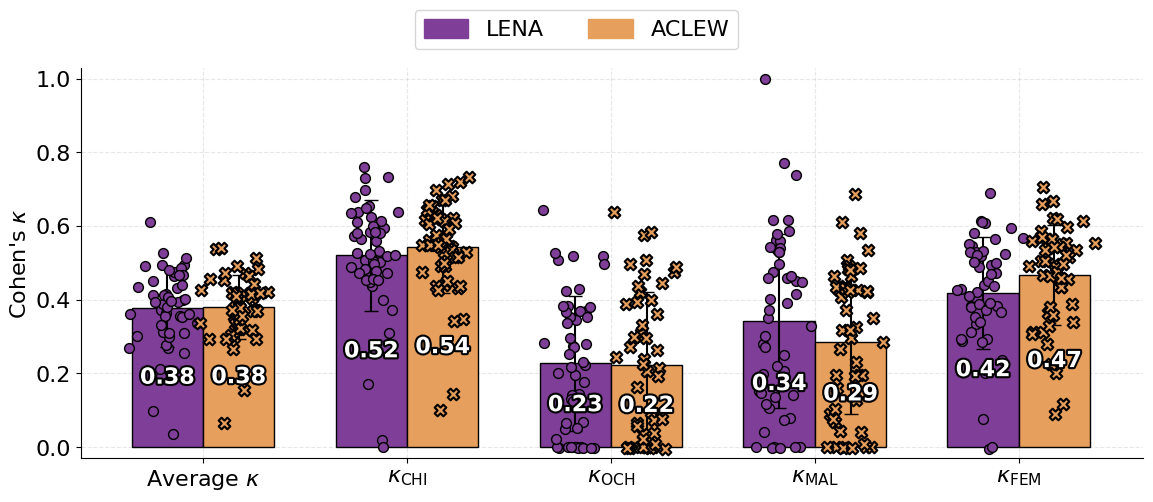

In [13]:
import matplotlib.pyplot as plt
import numpy as np
matplotlib.rcParams.update({'font.size': 16, 'legend.handleheight': 1, 'hatch.linewidth': 1.0,
                          'lines.markersize': 10, 'lines.linewidth': 2, 'errorbar.capsize': 5,
                           'xtick.labelsize': 16, 'ytick.labelsize': 16})

def plot_kappa_metrics(kappa_lena, kappa_vtc):
    cm = 1/2.54
    lena_color = '#7F3E97'
    aclew_color = '#E69F5C'
    alpha = 1
    
    metric_name = ['Average $\kappa$', r'$\kappa_{\text{CHI}}$', r'$\kappa_{\text{OCH}}$', 
                   r'$\kappa_{\text{MAL}}$', r'$\kappa_{\text{FEM}}$']
    metrics = ['kappa', 'kappa_CHI', 'kappa_OCH', 'kappa_MAL', 'kappa_FEM']
    
    x = np.arange(len(metrics))
    width = 0.35
    
    lena_means = [kappa_lena[m].mean() for m in metrics]
    lena_stds = [kappa_lena[m].std() for m in metrics]
    vtc_means = [kappa_vtc[m].mean() for m in metrics]
    vtc_stds = [kappa_vtc[m].std() for m in metrics]
    
    fig_width = 6 * len(metrics)
    fig, ax = plt.subplots(1, 1, figsize=(fig_width*cm, 12*cm))
    
    error_props = dict(ecolor='black', elinewidth=1.5, capsize=5, capthick=1)
    
    # Plot bars
    ax.bar(x - width/2, lena_means, width, 
           yerr=lena_stds,
           label='LENA', 
           color=lena_color,
           edgecolor='black',
           alpha=alpha,
           zorder=2,
           error_kw=error_props)
           
    ax.bar(x + width/2, vtc_means, width,
           yerr=vtc_stds,
           label='ACLEW', 
           color=aclew_color,
           edgecolor='black',
           alpha=alpha,
           zorder=2,
           error_kw=error_props)
    
    # Add scatter points
    for i, metric in enumerate(metrics):
        lena_data = kappa_lena[metric]
        vtc_data = kappa_vtc[metric]
        
        jitter = width/6
        x_jitter = np.random.normal(0, jitter, size=len(lena_data))
        
        # LENA scatter points
        ax.scatter(x[i]-width/2 + x_jitter, lena_data, 
                  color=lena_color,
                  edgecolor='black',
                  s=50,
                  linewidth=1,
                  zorder=3)
        
        # ACLEW scatter points
        ax.scatter(x[i]+width/2 + x_jitter, vtc_data, 
                  color=aclew_color,
                  edgecolor='black',
                  s=70,
                  marker='X',
                  linewidth=1.5,
                  zorder=3)
    
    # Add value labels in middle of bars
    for i, (lena_mean, vtc_mean) in enumerate(zip(lena_means, vtc_means)):
        # LENA value
        text = ax.text(i - width/2, lena_mean/2, 
                f'{lena_mean:.2f}',
                ha='center',
                va='center',
                color='white',
                weight='bold',
                zorder=3,
                size=16)
        text.set_path_effects([path_effects.withStroke(linewidth=3, foreground='black')])
        
        # ACLEW value
        text = ax.text(i + width/2, vtc_mean/2,
                f'{vtc_mean:.2f}',
                ha='center',
                va='center',
                color='white',
                weight='bold',
                zorder=3,
                size=16)
        text.set_path_effects([path_effects.withStroke(linewidth=3, foreground='black')])
    
    ax.set_ylabel("Cohen's $\kappa$")
    ax.set_ylim(-0.03, 1.03)
    ax.set_xticks(x)
    ax.set_xticklabels(metric_name)
    ax.grid(True, linestyle='--', alpha=0.3, zorder=0)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    handles = [plt.Rectangle((0,0),1,1, color=lena_color), plt.Rectangle((0,0),1,1, color=aclew_color)]
    labels = ['LENA', 'ACLEW']
    fig.legend(handles, labels, ncol=2, bbox_to_anchor=(0.5, 1.03), loc='center', frameon=True)
    
    plt.tight_layout()
    return fig, ax

plot_kappa_metrics(kappa_lena, kappa_vtc)
plt.savefig('/home/engaclew/neurogen/figures/30mn/lena_vtc_kappa.png', dpi=300)
plt.show()


In [18]:
from scipy import stats

def add_group_significance_bars(ax, df, groups, col):
    def get_stars(p_value):
        if p_value < 0.001:
            return '***'
        elif p_value < 0.01:
            return '**'
        elif p_value < 0.05:
            return '*'
        return ''
    
    # Get y-axis range
    ymin, ymax = ax.get_ylim()
    ydist = ymax - ymin
    
    # Calculate relative spacings
    stars_spacing = 0.01 * ydist  # Space between bar and stars
    bar_spacing = 0.07 * ydist    # Space between multiple bars
    tick_height = 0.02 * ydist    # Length of vertical ticks
    base_height = ymax + (0.05 * ydist)  # Starting height above plot
    
    # Perform statistical tests against low_risk group
    control_group = 'low_risk'
    control_data = df[df['group_id'] == control_group][col]
    
    # Calculate spacing in axes coordinates
    trans = ax.transAxes.inverted()
    x_positions = range(len(groups))
    
    sig_count = 0
    
    for i, group in enumerate(groups[1:], 1):
        if group in df['group_id'].unique():
            test_data = df[df['group_id'] == group][col]
            
            # Perform Mann-Whitney U test
            statistic, p_value = stats.mannwhitneyu(
                control_data, 
                test_data,
                alternative='two-sided'
            )
            
            # Only add bars for significant results
            stars = get_stars(p_value)
            if stars:
                current_height = base_height + (sig_count * bar_spacing)
                sig_count += 1
                
                # Draw the bar
                ax.plot(
                    [0, i],
                    [current_height, current_height],
                    'k-',
                    linewidth=1,
                    transform=ax.transData,
                    clip_on=False
                )
                
                # Add vertical ticks
                ax.plot(
                    [0, 0],
                    [current_height - tick_height, current_height],
                    'k-',
                    linewidth=1,
                    clip_on=False
                )
                ax.plot(
                    [i, i],
                    [current_height - tick_height, current_height],
                    'k-',
                    linewidth=1,
                    clip_on=False
                )
                
                # Add stars
                ax.text(
                    (0 + i) / 2,
                    current_height + stars_spacing,  # Using relative spacing
                    stars,
                    ha='center',
                    va='center',
                    fontsize=12,
                    clip_on=False
                )
    
    # Maintain original y-axis limits
    ax.set_ylim(ymin, ymax)
    ax.set_clip_on(False)

/tmp/ipykernel_83481/3691436320.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = df.groupby('group_id')[fscore_col].mean().reindex(groups, fill_value=0)
/tmp/ipykernel_83481/3691436320.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stds = df.groupby('group_id')[fscore_col].std().reindex(groups, fill_value=0)


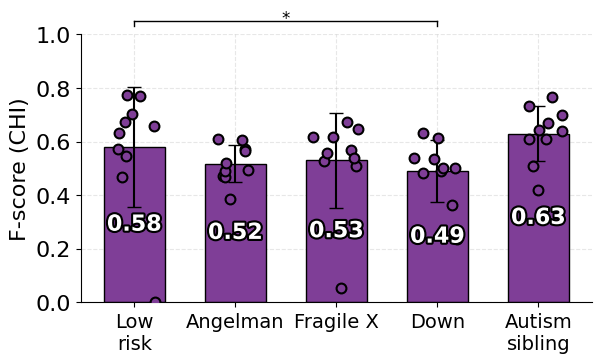

/tmp/ipykernel_83481/3691436320.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = df.groupby('group_id')[fscore_col].mean().reindex(groups, fill_value=0)
/tmp/ipykernel_83481/3691436320.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stds = df.groupby('group_id')[fscore_col].std().reindex(groups, fill_value=0)


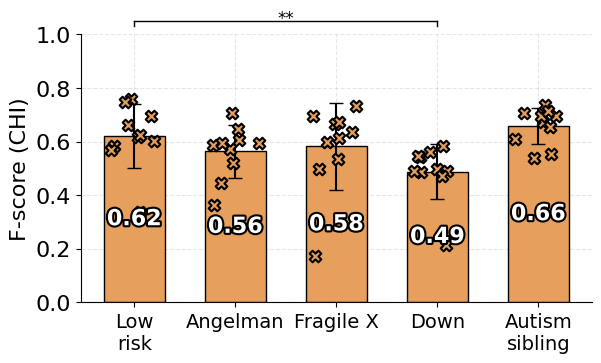

/tmp/ipykernel_83481/3691436320.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = df.groupby('group_id')[fscore_col].mean().reindex(groups, fill_value=0)
/tmp/ipykernel_83481/3691436320.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stds = df.groupby('group_id')[fscore_col].std().reindex(groups, fill_value=0)


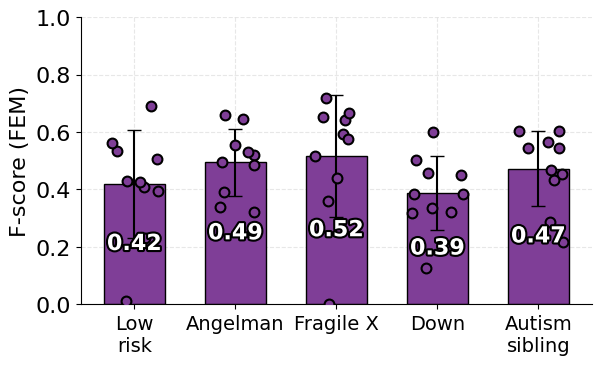

/tmp/ipykernel_83481/3691436320.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = df.groupby('group_id')[fscore_col].mean().reindex(groups, fill_value=0)
/tmp/ipykernel_83481/3691436320.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stds = df.groupby('group_id')[fscore_col].std().reindex(groups, fill_value=0)


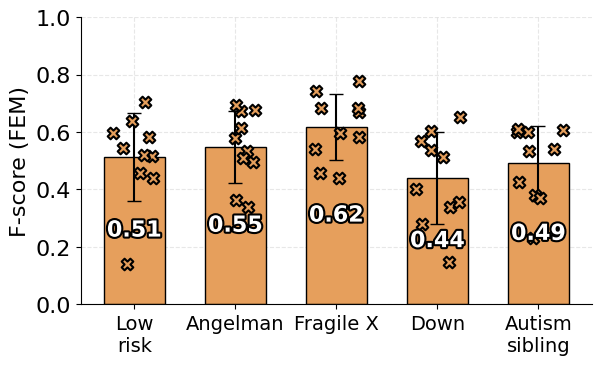

In [19]:
def plot_fscore_by_group(df, color, marker, cat='CHI'):
    if cat not in ['CHI', 'FEM', 'MAL', 'OCH']:
        raise ValueError("cat must be either 'CHI' or 'FEM'")
        
    fscore_col = f'fscore_{cat}'
    
    jitter_width = 0.25
    alpha = 1
    size = 50
    if marker == 'X':
        size = 70
    cm = 1/2.54
    
    label_name = {
        'low_risk': 'Low\nrisk',
        'angelman_syndrome': 'Angelman',
        'fragile_x_syndrome': 'Fragile X',
        'down_syndrome': 'Down',
        'autism_sibling': 'Autism\nsibling'
    }
    
    groups = list(label_name.keys())
    available_groups = df['group_id'].unique()
    
    # Calculate statistics
    means = df.groupby('group_id')[fscore_col].mean().reindex(groups, fill_value=0)
    stds = df.groupby('group_id')[fscore_col].std().reindex(groups, fill_value=0)
    
    # Plotting
    fig, ax = plt.subplots(figsize=(16*cm, 10*cm))
    
    x = np.arange(len(groups))
    width = 0.6
    
    # Create bars
    bars = ax.bar(x, means, width,
                 yerr=stds,
                 color=color,
                 alpha=alpha,
                 zorder=2,
                 edgecolor='black',
                 error_kw=dict(ecolor='black', elinewidth=1.5, capsize=5, capthick=1))
    
    # Add individual points
    for i, group in enumerate(groups):
        if group in available_groups:
            group_data = df[df['group_id'] == group][fscore_col]
            jitter = np.random.uniform(-jitter_width, jitter_width, size=len(group_data))
            ax.scatter(x[i] + jitter, group_data, 
                      color=color,
                      edgecolor='black',
                      s=size,
                      marker=marker,
                      linewidth=1.5,
                      zorder=3)
    
    # Add value labels in middle of bars
    for i, mean_val in enumerate(means):
        if mean_val > 0:  # Only add label if there's a bar
            # Position text at half the bar height
            y_pos = mean_val / 2
            
            text = ax.text(i, y_pos, 
                    f'{mean_val:.2f}',
                    ha='center',
                    va='center',
                    color='white',
                    weight='bold',
                    zorder=3,
                    size=16)
            text.set_path_effects([path_effects.withStroke(linewidth=3, foreground='black')])
    
    # Customize plot
    ax.set_ylabel(f'F-score ({cat})')  # Changed from kappa to F-score
    ax.set_ylim(0, 1.0)
    ax.set_xticks(x)
    ax.set_xticklabels([label_name[g] for g in groups], rotation=0, fontsize=14)
    ax.grid(True, linestyle='--', alpha=0.3, zorder=0)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    add_group_significance_bars(ax, df, groups, fscore_col)
    plt.tight_layout()
    return fig, ax

plot_fscore_by_group(fscore_lena, color=lena_color, marker='o', cat='CHI')
plt.savefig('/home/engaclew/neurogen/figures/30mn_group/lena_fscore_CHI.png', dpi=300)
plt.show()
plot_fscore_by_group(fscore_vtc, color=aclew_color, marker='X', cat='CHI')
plt.savefig('/home/engaclew/neurogen/figures/30mn_group/vtc_fscore_CHI.png', dpi=300)
plt.show()
plot_fscore_by_group(fscore_lena, color=lena_color, marker='o', cat='FEM')
plt.savefig('/home/engaclew/neurogen/figures/30mn_group/lena_fscore_FEM.png', dpi=300)
plt.show()
plot_fscore_by_group(fscore_vtc, color=aclew_color, marker='X', cat='FEM')
plt.savefig('/home/engaclew/neurogen/figures/30mn_group/vtc_fscore_FEM.png', dpi=300)
plt.show()



In [21]:
from pathlib import Path
import pandas as pd
import numpy as np
results_folder = Path('/home/engaclew/neurogen/results/pyannote_metrics')

# Load f-score
fscore_lena = pd.read_csv(results_folder / 'its_eaf_an1' / 'fscore_30mn_clips.csv')
fscore_vtc = pd.read_csv(results_folder / 'vtc_eaf_an1' / 'fscore_30mn_clips.csv')
# Order
desired_order = ['low_risk', 'angelman_syndrome', 'fragile_x_syndrome', 'down_syndrome', 'autism_sibling']
fscore_lena['group_id'] = pd.Categorical(fscore_lena['group_id'], categories=desired_order, ordered=True)
fscore_vtc['group_id'] = pd.Categorical(fscore_vtc['group_id'], categories=desired_order, ordered=True)
fscore_lena = fscore_lena.sort_values('group_id')
fscore_vtc = fscore_vtc.sort_values('group_id')

print('Computing on %d chunks' % len(fscore_lena))
def compute_fscore(fscore_data):
    speakers = ['CHI', 'FEM', 'MAL', 'OCH']
    for speaker in speakers:
        # Precision = 1 if retrieved == 0 (all retrieved instances are correct since there was no retrieve instances
        fscore_data[f'precision_{speaker}'] = np.where(
            fscore_data[f'retrieved_{speaker}'] == 0,
            1,
            fscore_data[f'relevant retrieved_{speaker}'] / fscore_data[f'retrieved_{speaker}']
        )
    
        # Recall = 1 if relevant is 0 (all actual instances have been found since there was no example)
        fscore_data[f'recall_{speaker}'] = np.where(
            (fscore_data[f'relevant_{speaker}'] == 0),
            1,
            fscore_data[f'relevant retrieved_{speaker}'] / fscore_data[f'relevant_{speaker}']
        )
    
        # F-score calculation
        numerator = 2 * fscore_data[f'precision_{speaker}'] * fscore_data[f'recall_{speaker}']
        denominator = fscore_data[f'precision_{speaker}'] + fscore_data[f'recall_{speaker}']
        fscore_data[f'fscore_{speaker}'] = np.where(denominator != 0, numerator / denominator, 0)

    total_duration = (fscore_data['relevant_CHI'] + fscore_data['relevant_OCH'] + 
                 fscore_data['relevant_FEM'] + fscore_data['relevant_MAL'])

    total_global_duration = fscore_data[['relevant_CHI', 'relevant_OCH', 'relevant_FEM', 'relevant_MAL']].sum().sum()
    global_weights = {spk: fscore_data[f'relevant_{spk}'].sum() / total_global_duration for spk in speakers}
    print(f'Weights: {global_weights}')
    for metric in ['precision', 'recall', 'fscore']:
        fscore_data[f'weighted_{metric}'] = 100*sum(
                fscore_data[f'{metric}_{spk}'] * global_weights[spk] 
                for spk in speakers
            )
        fscore_data[metric] = 100 * fscore_data[[f'{metric}_{spk}' for spk in speakers]].mean(axis=1)
    return fscore_data

fscore_lena = compute_fscore(fscore_lena)
fscore_vtc = compute_fscore(fscore_vtc)

# Get human measures
DATA_PATH = Path('/home/engaclew/neurogen')
human_measures = pd.read_csv(DATA_PATH / 'human_measures_chunks.csv').fillna(0)
children = pd.read_csv(DATA_PATH / 'data/L3_HIPAA_LENA_cleaned/metadata/children.csv')
recordings = pd.read_csv(DATA_PATH / 'data/L3_HIPAA_LENA_cleaned/metadata/recordings.csv')
recordings_data = recordings.merge(children, on='child_id')[['group_id', 'recording_filename']]
human_measures = human_measures.merge(recordings_data, how='left', on='recording_filename')
def group_measures(data):
    if 'can_voc_CHI' in data.columns and 'non_can_voc_CHI' in data.columns:
        data['CVC'] = data['can_voc_CHI'] + data['non_can_voc_CHI']
    data = data.groupby('recording_filename').agg({
        '5s_CTC': np.sum,
        'voc_dur_chi': np.sum,
        'voc_chi': np.sum,
        'avg_voc_dur_chi': np.mean,
        'wc_adu': np.sum,
        'CVC': np.sum,
        'group_id': 'first',
        'child_id': 'first'
    }).reset_index()
    return data

human_measures = group_measures(human_measures)
fscore_vtc = fscore_vtc.merge(human_measures, left_on='recording_id', right_on='recording_filename', suffixes=('', '_human'))
fscore_lena = fscore_lena.merge(human_measures, left_on='recording_id', right_on='recording_filename', suffixes=('', '_human'))
print(fscore_vtc.columns)

Computing on 50 chunks
Weights: {'CHI': 0.33801821016216804, 'FEM': 0.40483508026272125, 'MAL': 0.12314295312470816, 'OCH': 0.13400375645040255}
Weights: {'CHI': 0.33801821016216804, 'FEM': 0.40483508026272125, 'MAL': 0.12314295312470816, 'OCH': 0.13400375645040255}
Index(['recording_id', 'group_id', 'retrieved_CHI', 'relevant_CHI',
       'relevant retrieved_CHI', 'fscore_CHI', 'retrieved_OCH', 'relevant_OCH',
       'relevant retrieved_OCH', 'fscore_OCH', 'retrieved_FEM', 'relevant_FEM',
       'relevant retrieved_FEM', 'fscore_FEM', 'retrieved_MAL', 'relevant_MAL',
       'relevant retrieved_MAL', 'fscore_MAL', 'precision_CHI', 'recall_CHI',
       'precision_FEM', 'recall_FEM', 'precision_MAL', 'recall_MAL',
       'precision_OCH', 'recall_OCH', 'weighted_precision', 'precision',
       'weighted_recall', 'recall', 'weighted_fscore', 'fscore',
       'recording_filename', '5s_CTC', 'voc_dur_chi', 'voc_chi',
       'avg_voc_dur_chi', 'wc_adu', 'CVC', 'group_id_human', 'child_id'],
 

/tmp/ipykernel_83481/584640840.py:66: FutureWarning: The provided callable <function sum at 0x7ae1a59c6ef0> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  data = data.groupby('recording_filename').agg({
/tmp/ipykernel_83481/584640840.py:66: FutureWarning: The provided callable <function sum at 0x7ae1a59c6ef0> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  data = data.groupby('recording_filename').agg({
/tmp/ipykernel_83481/584640840.py:66: FutureWarning: The provided callable <function mean at 0x7ae1a59c7e20> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  data = data.groupby('recording_filename').agg({


Text(0.5, 1.0, 'F-score vs Average Vocalization Duration by Group')

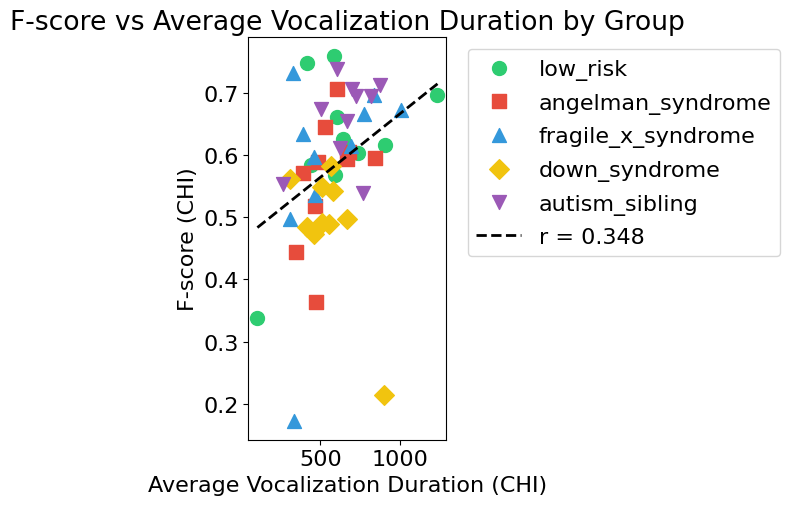

In [22]:
markers = {
    'low_risk': 'o',           # circle
    'angelman_syndrome': 's',   # square
    'fragile_x_syndrome': '^',  # triangle up
    'down_syndrome': 'D',       # diamond
    'autism_sibling': 'v'       # triangle down
}

colors = {
    'low_risk': '#2ecc71',         # green
    'angelman_syndrome': '#e74c3c', # red
    'fragile_x_syndrome': '#3498db',# blue
    'down_syndrome': '#f1c40f',     # yellow
    'autism_sibling': '#9b59b6'     # purple
}

# Plot scatter points for each group
for group in markers.keys():
    mask = fscore_vtc['group_id'] == group
    plt.scatter(
        fscore_vtc.loc[mask, 'avg_voc_dur_chi'],
        fscore_vtc.loc[mask, 'fscore_CHI'],
        marker=markers[group],
        c=colors[group],
        label=group,
        s=100
    )

# Calculate and plot single regression line for all data
x = fscore_vtc['avg_voc_dur_chi']
y = fscore_vtc['fscore_CHI']
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

# Create regression line points
line_x = np.array([min(x), max(x)])
line_y = slope * line_x + intercept

# Plot the regression line
plt.plot(line_x, line_y, 'k--', label=f'r = {r_value:.3f}')

# Add legend to the right of the graph
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust the layout to prevent legend cutoff
plt.tight_layout()

plt.xlabel('Average Vocalization Duration (CHI)')
plt.ylabel('F-score (CHI)')
plt.title('F-score vs Average Vocalization Duration by Group')

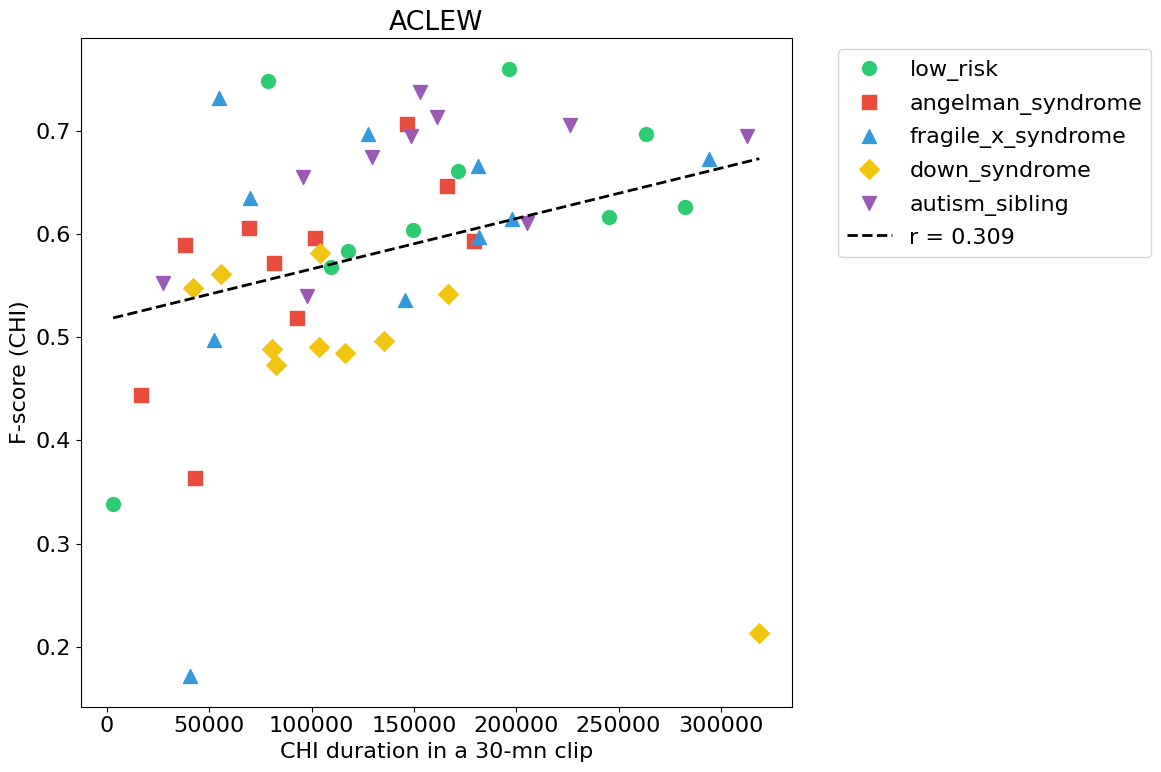

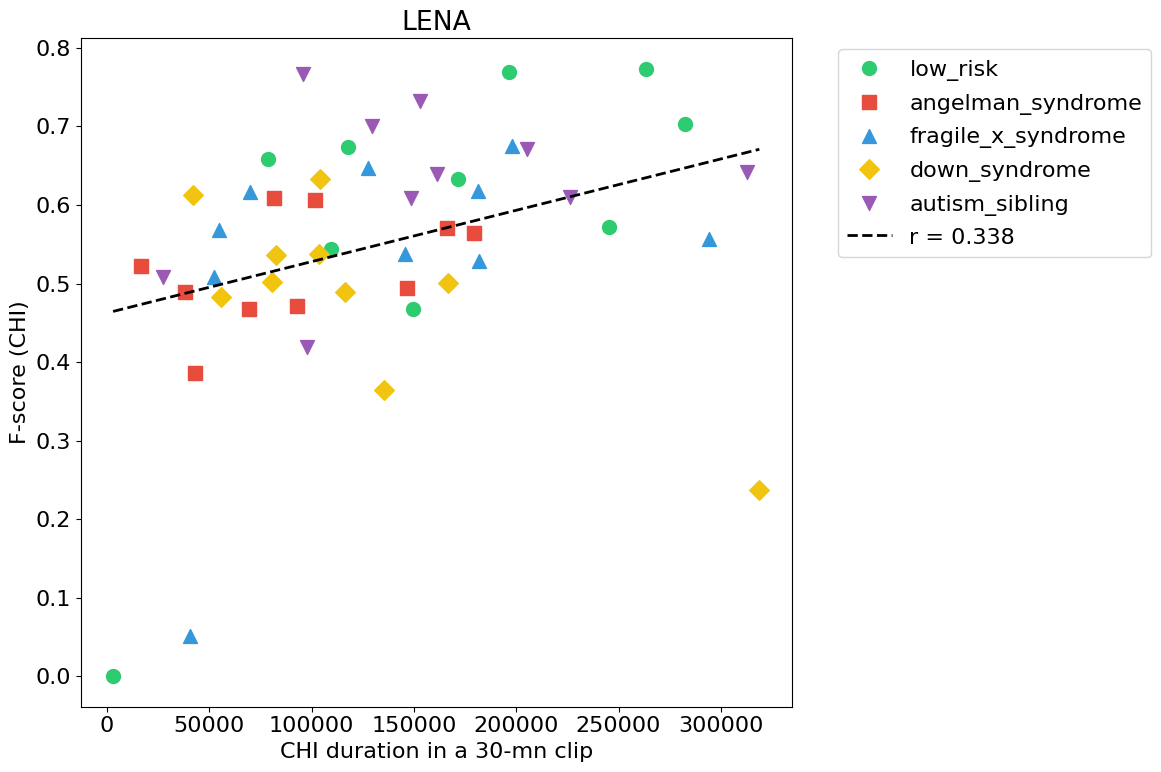

In [23]:
import numpy as np
from scipy import stats

# Create dictionaries for markers and colors
markers = {
    'low_risk': 'o',           # circle
    'angelman_syndrome': 's',   # square
    'fragile_x_syndrome': '^',  # triangle up
    'down_syndrome': 'D',       # diamond
    'autism_sibling': 'v'       # triangle down
}

colors = {
    'low_risk': '#2ecc71',         # green
    'angelman_syndrome': '#e74c3c', # red
    'fragile_x_syndrome': '#3498db',# blue
    'down_syndrome': '#f1c40f',     # yellow
    'autism_sibling': '#9b59b6'     # purple
}

# ACLEW Plot
plt.figure(figsize=(12, 8))

# Plot scatter points for each group - ACLEW
for group in markers.keys():
    mask = fscore_vtc['group_id'] == group
    plt.scatter(
        fscore_vtc.loc[mask, 'voc_dur_chi'],
        fscore_vtc.loc[mask, 'fscore_CHI'],
        marker=markers[group],
        c=colors[group],
        label=group,
        s=100
    )

# Calculate and plot regression line - ACLEW
x_aclew = fscore_vtc['voc_dur_chi']
y_aclew = fscore_vtc['fscore_CHI']
slope_aclew, intercept_aclew, r_value_aclew, p_value_aclew, std_err_aclew = stats.linregress(x_aclew, y_aclew)

line_x_aclew = np.array([min(x_aclew), max(x_aclew)])
line_y_aclew = slope_aclew * line_x_aclew + intercept_aclew

plt.plot(line_x_aclew, line_y_aclew, 'k--', label=f'r = {r_value_aclew:.3f}')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('CHI duration in a 30-mn clip')
plt.ylabel('F-score (CHI)')
plt.title('ACLEW')
plt.tight_layout()
plt.savefig('/home/engaclew/neurogen/figures/30mn_group/aclew_cum_dur_as_fscore_chi.png', dpi=300)
plt.show()

# LENA Plot
plt.figure(figsize=(12, 8))

# Plot scatter points for each group - LENA
for group in markers.keys():
    mask = fscore_lena['group_id'] == group
    plt.scatter(
        fscore_lena.loc[mask, 'voc_dur_chi'],
        fscore_lena.loc[mask, 'fscore_CHI'],
        marker=markers[group],
        c=colors[group],
        label=group,
        s=100
    )

# Calculate and plot regression line - LENA
x_lena = fscore_lena['voc_dur_chi']
y_lena = fscore_lena['fscore_CHI']
slope_lena, intercept_lena, r_value_lena, p_value_lena, std_err_lena = stats.linregress(x_lena, y_lena)

line_x_lena = np.array([min(x_lena), max(x_lena)])
line_y_lena = slope_lena * line_x_lena + intercept_lena

plt.plot(line_x_lena, line_y_lena, 'k--', label=f'r = {r_value_lena:.3f}')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('CHI duration in a 30-mn clip')
plt.ylabel('F-score (CHI)')
plt.title('LENA')
plt.tight_layout()
plt.savefig('/home/engaclew/neurogen/figures/30mn_group/lena_cum_dur_as_fscore_chi.png', dpi=300)
plt.show()

In [30]:
# IDER
from pathlib import Path
import pandas as pd
import numpy as np
results_folder = Path('/home/engaclew/neurogen/results/pyannote_metrics')

# Load ider
ider_vtc = pd.read_csv(results_folder / 'vtc_eaf_an1' / 'ider_30mn_clips.csv')
ider_lena = pd.read_csv(results_folder / 'its_eaf_an1' / 'ider_30mn_clips.csv')

def compute_ider(ider_df):
    ider_df['missed detection'] = 100*ider_df['missed detection'] / ider_df['total']
    ider_df['false alarm'] = 100*ider_df['false alarm'] / ider_df['total']
    ider_df['confusion'] = 100*ider_df['confusion'] / ider_df['total']
    ider_df['correct'] = 100*ider_df['correct'] / ider_df['total']
    ider_df['ider'] = 100*ider_df['ider']
    return ider_df

ider_vtc = compute_ider(ider_vtc)
ider_lena = compute_ider(ider_lena)
print(ider_vtc.head())

                   recording_id            group_id    correct     total  \
0  20190828_145547_024884_2.wav   angelman_syndrome  80.625677  704804.0   
1  20211022_110857_045737_2.wav  fragile_x_syndrome  79.763435  221757.0   
2    20180808_110630_024879.wav            low_risk  76.555641  362680.0   
3  20221129_154915_045733_1.wav  fragile_x_syndrome  73.613361  467407.0   
4  20230110_120835_024882_2.wav      autism_sibling  83.609107  239206.0   

   false alarm  confusion  missed detection        ider  
0    68.673277  11.928990          7.445332   88.047599  
1    40.867256   6.710498         13.526067   61.103821  
2    85.632789  12.445131         10.999228  109.077148  
3    70.621321  16.546393          9.840246   97.007961  
4   124.368118  10.019398          6.371496  140.759011  


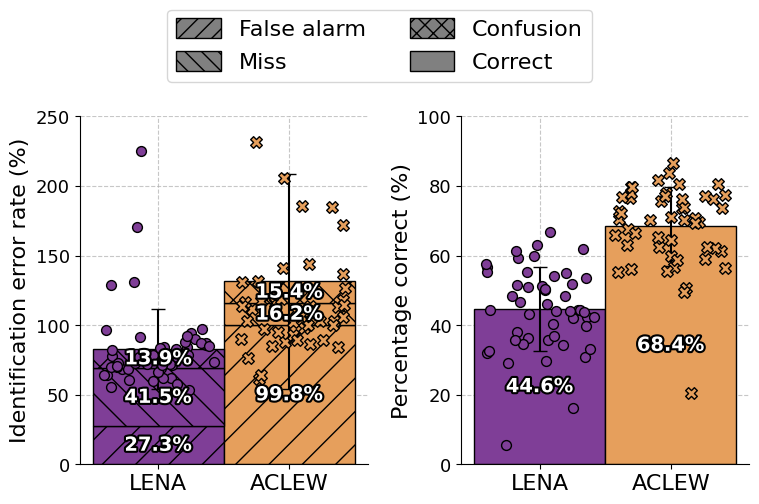

In [33]:
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patheffects as path_effects
import numpy as np

matplotlib.rcParams.update({'font.size': 16, 'legend.handleheight': 1, 'hatch.linewidth': 1.0,
                          'lines.markersize': 10, 'lines.linewidth': 2, 'errorbar.capsize': 5,
                           'xtick.labelsize': 13, 'ytick.labelsize': 13})

cm = 1/2.54

def plot_identification_errors(ider_lena, ider_vtc):
    lena_color = '#7F3E97'
    aclew_color = '#E69F5C'
    fontsize=14
    # Calculate means
    lena_means = {
        'false_alarm': ider_lena['false alarm'].mean(),
        'miss': ider_lena['missed detection'].mean(),
        'confusion': ider_lena['confusion'].mean(),
        'correct': ider_lena['correct'].mean()
    }
    
    vtc_means = {
        'false_alarm': ider_vtc['false alarm'].mean(),
        'miss': ider_vtc['missed detection'].mean(),
        'confusion': ider_vtc['confusion'].mean(),
        'correct': ider_vtc['correct'].mean()
    }
    
    error_types = ['false_alarm', 'miss', 'confusion']
    patterns = ['/', '\\', 'x']
    lena_errors = [lena_means[et] for et in error_types]
    vtc_errors = [vtc_means[et] for et in error_types]
    
    fig = plt.figure(figsize=(20*cm, 12*cm))
    gs = fig.add_gridspec(1, 2)
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1])
    width = 0.35
    
    # First subplot - Error rates
    ax1.grid(True, linestyle='--', alpha=0.7, zorder=0)
    
    bottom_lena = 0
    bottom_vtc = 0
    for i, error_type in enumerate(error_types):
        ax1.bar(-width/2, lena_errors[i], width, 
               bottom=bottom_lena,
               color=lena_color, edgecolor='black',
               hatch=patterns[i], zorder=2)
        ax1.bar(width/2, vtc_errors[i], width,
               bottom=bottom_vtc,
               color=aclew_color, edgecolor='black',
               hatch=patterns[i], zorder=2)
        
        if lena_errors[i] > 5:
            text = ax1.text(-width/2, bottom_lena + lena_errors[i]/2, 
                    f'{lena_errors[i]:.1f}%', 
                    ha='center', va='center', color='white', 
                    weight='bold', size=fontsize, zorder=4)
            text.set_path_effects([path_effects.withStroke(linewidth=3, foreground='black')])
            
        if vtc_errors[i] > 5:
            text = ax1.text(width/2, bottom_vtc + vtc_errors[i]/2, 
                    f'{vtc_errors[i]:.1f}%', 
                    ha='center', va='center', color='white', 
                    weight='bold', size=fontsize, zorder=4)
            text.set_path_effects([path_effects.withStroke(linewidth=3, foreground='black')])
        
        bottom_lena += lena_errors[i]
        bottom_vtc += vtc_errors[i]
    
    # Add individual points with jitter and std errors for error rates
    jitter_width = 0.15
    lena_ider_mean = ider_lena['ider'].mean()
    lena_ider_std = ider_lena['ider'].std()
    vtc_ider_mean = ider_vtc['ider'].mean()
    vtc_ider_std = ider_vtc['ider'].std()
    
    jitter = np.random.uniform(-jitter_width, jitter_width, size=len(ider_lena))
    ax1.scatter([-width/2 + j for j in jitter], ider_lena['ider'],
               color=lena_color, edgecolor='black',
               s=50, zorder=3)
    ax1.errorbar(-width/2, lena_ider_mean, yerr=lena_ider_std,
                color='black', elinewidth=1.5, capsize=5, capthick=1, zorder=2)
    
    jitter = np.random.uniform(-jitter_width, jitter_width, size=len(ider_vtc))
    ax1.scatter([width/2 + j for j in jitter], ider_vtc['ider'],
               color=aclew_color, edgecolor='black',
               s=70, marker='X', zorder=3)
    ax1.errorbar(width/2, vtc_ider_mean, yerr=vtc_ider_std,
                color='black', elinewidth=1.5, capsize=5, capthick=1, zorder=2)
                
    
    ax1.set_xticks([-width/2, width/2])
    ax1.set_xticklabels(['LENA', 'ACLEW'], fontsize=16)
    ax1.set_ylabel('Identification error rate (%)')
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    
    # Second subplot - Correct percentage
    ax2.grid(True, linestyle='--', alpha=0.7, zorder=0)
    
    # Plot bars for correct percentage
    ax2.bar(-width/2, lena_means['correct'], width,
            color=lena_color, edgecolor='black', zorder=2)
    ax2.bar(width/2, vtc_means['correct'], width,
            color=aclew_color, edgecolor='black', zorder=2)
    
    # Add individual points with jitter and std errors for correct percentage
    lena_correct_mean = ider_lena['correct'].mean()
    lena_correct_std = ider_lena['correct'].std()
    vtc_correct_mean = ider_vtc['correct'].mean()
    vtc_correct_std = ider_vtc['correct'].std()
    
    jitter = np.random.uniform(-jitter_width, jitter_width, size=len(ider_lena))
    ax2.scatter([-width/2 + j for j in jitter], ider_lena['correct'],
               color=lena_color, edgecolor='black',
               s=50, zorder=3)
    ax2.errorbar(-width/2, lena_correct_mean, yerr=lena_correct_std,
                color='black', elinewidth=1.5, capsize=5, capthick=1, zorder=2)
    
    jitter = np.random.uniform(-jitter_width, jitter_width, size=len(ider_vtc))
    ax2.scatter([width/2 + j for j in jitter], ider_vtc['correct'],
               color=aclew_color, edgecolor='black',
               s=70, marker='X', zorder=3)
    ax2.errorbar(width/2, vtc_correct_mean, yerr=vtc_correct_std,
                color='black', elinewidth=1.5, capsize=5, capthick=1, zorder=2)
           
    # Add percentage labels
    text = ax2.text(-width/2, lena_means['correct']/2,
            f'{lena_means["correct"]:.1f}%',
            ha='center', va='center', color='white',
            weight='bold', size=fontsize, zorder=4)
    text.set_path_effects([path_effects.withStroke(linewidth=3, foreground='black')])
    
    text = ax2.text(width/2, vtc_means['correct']/2,
            f'{vtc_means["correct"]:.1f}%',
            ha='center', va='center', color='white',
            weight='bold', size=fontsize, zorder=4)
    text.set_path_effects([path_effects.withStroke(linewidth=3, foreground='black')])
    
    ax2.set_xticks([-width/2, width/2])
    ax2.set_xticklabels(['LENA', 'ACLEW'], fontsize=16)
    ax2.set_ylabel('Percentage correct (%)')
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    
    # Set independent y-axis limits
    ax1.set_ylim(0, max(ider_lena['ider'].max(), ider_vtc['ider'].max()) + 10)  # +10 for label space
    ax2.set_ylim(0, 100) 
    
    # Legend
    handles = [
        plt.Rectangle((0,0),1,1, facecolor='gray', edgecolor='black', hatch='//'),
        plt.Rectangle((0,0),1,1, facecolor='gray', edgecolor='black', hatch='\\\\'),
        plt.Rectangle((0,0),1,1, facecolor='gray', edgecolor='black', hatch='xx'),
        plt.Rectangle((0,0),1,1, facecolor='gray', edgecolor='black')
    ]
    labels = ['False alarm', 'Miss', 'Confusion', 'Correct']
    
    fig.legend(handles, labels, 
              bbox_to_anchor=(0.5, 1.0),
              loc='center',
              ncol=2,
              handlelength=2,
              handleheight=1)
    ax1.set_ylim(0, 250)
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    return fig, (ax1, ax2)

# Usage:
fig, (ax1, ax2) = plot_identification_errors(ider_lena, ider_vtc)
plt.savefig('/home/engaclew/neurogen/figures/30mn/ider.png', dpi=300, bbox_inches='tight')

plt.show()


In [34]:
print(ider_vtc['false alarm'].mean(), ider_vtc['false alarm'].std())
print(ider_vtc['missed detection'].mean(), ider_vtc['missed detection'].std())
print(ider_vtc['confusion'].mean(), ider_vtc['confusion'].std())
print(ider_vtc['ider'].mean(), ider_vtc['ider'].std())

99.76741711387531 74.50141948418731
16.24580504482808 9.03439871713698
15.352696214906548 5.689461343993101
131.36591837360993 77.05866353957938


In [35]:
print(ider_vtc['false alarm'].min(), ider_vtc['false alarm'].max())
print(ider_lena['false alarm'].min(), ider_lena['false alarm'].max())

40.867255599597755 483.61486820999266
5.817150956768249 132.20830349380932


In [36]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Define colors
lena_color = '#7F3E97'
aclew_color = '#E69F5C'

# Create a figure with a white background
fig, ax = plt.subplots(figsize=(6, 1), dpi=300, 
                       facecolor='white',  # Explicitly set white background
                       edgecolor='black',  # Add border
                       linewidth=1)  # Border width

# Create handles using colored rectangles
handles = [
    plt.Rectangle((0,0),1,1, color=lena_color),
    plt.Rectangle((0,0),1,1, color=aclew_color)
]

# Labels
labels = ['LENA', 'ACLEW']

# Create legend
legend = plt.legend(handles, labels, 
                    ncol=2,  
                    loc='center',
                    frameon=True)

# Remove axes
plt.axis('off')

# Adjust subplot parameters to remove internal padding
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)

# Save the figure with tight bounding box and white background
plt.savefig('/home/engaclew/neurogen/figures/legend.png', 
            bbox_inches='tight',
            dpi=800,
            pad_inches=0,
            facecolor='white',  # Ensure white background
            edgecolor='none')  # No extra edge

plt.close()